# MVPA and Searchlight with `nilearn`

In this section we will show how you can use `nilearn` to perform multivariate pattern analysis (MVPA), either in a specific region of interest (ROI) or directly in the whole brain, for example with a Searchlight analysis.


## `nilearn`

Although nilearn's visualizations are quite nice, its primary purpose was to facilitate machine learning in neuroimaging. It's in some sense the bridge between [nibabel](http://nipy.org/nibabel/) and [scikit-learn](http://scikit-learn.org/stable/). On the one hand, it reformats images to be easily passed to scikit-learn, and on the other, it reformats the results to produce valid nibabel images.

<div class="alert alert-danger">
<h3>Disclaimer</h3>
<b>First</b>: This section is heavily based on the <a href="https://nilearn.github.io/decoding/index.html">nilearn tutorials</a>.
    
<b>Second</b>: This section is not intended to teach machine learning, but to demonstrate a simple nilearn pipeline.
</div>

## Setup

In [1]:
import numpy as np
import nibabel as nb
import pandas as pd
from nilearn.image import resample_to_img, math_img, mean_img

%matplotlib inline
import matplotlib.pyplot as plt

## Locate and verify the machine learning dataset
First, let's verify the location and size of the dataset we prepared in the previous notebook:

In [2]:
func = '/home/neuro/workshop/notebooks/data/dataset_ML.nii.gz'
!nib-ls $func

/home/neuro/workshop/notebooks/data/dataset_ML.nii.gz float32 [ 40,  51,  41, 384] 4.00x4.00x4.00x1.00



In [3]:
# For quicker access, let's also create a functional mean image
img_mean = mean_img(func)
img_mean.shape

(40, 51, 41)

## Creating masks

Now, let's create multiple masks to better restrict some of our analysis. What we'll need is a mask for the brain (and in this case exceptionally also the eyes), as well as a mask for three different regions of interests (ROI): The primary visual cortex (V1), the primary audiotry cortex (A1) and the eyes (EYE).

In [4]:
from nilearn.plotting import plot_roi

In [5]:
def create_mask(img_roi, img_mean):
    
    # Resample mask to functional space
    img_resampled = resample_to_img(img_roi, img_mean)

    # Binarize ROI template
    data_binary = np.array(img_resampled.get_fdata()!=0, dtype=np.int8)

    # Dilate binary mask once
    data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)

    # Save binary mask in NIfTI image
    mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
    
    # Restrict mask only to voxels with functional values
    mask = math_img("(mean * mask)>0", mean=img_mean, mask=mask)
    mask.set_data_dtype('i1')
    
    return mask

Now that we're ready, let's create some masks!

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


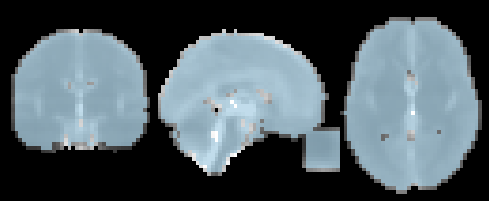

In [6]:
# Create global mask containing brain and eyes
brain = '/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm_brain.nii.gz'
eyes = '/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm_eye.nii.gz'
img_roi = math_img("(img1 + img2)>0", img1=brain, img2=eyes)
img_resampled = resample_to_img(img_roi, img_mean)
mask_global = math_img("((mean!=0)*img)>0.5", mean=img_mean, img=img_resampled)

# Plotting global mask
anat = '/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm.nii.gz'
plot_roi(mask_global, img_mean, cmap='Paired', dim=-.5, draw_cross=False, annotate=False);

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


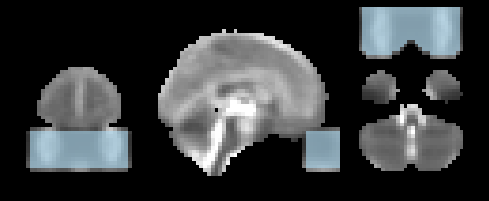

In [7]:
# Create eye mask containing both eyes
img_roi = math_img("img>0", img=eyes)
img_resampled = resample_to_img(img_roi, img_mean)
mask_eye = math_img("((mean!=0)*img)>0.5", mean=img_mean, img=img_resampled)

# Plotting global mask
anat = '/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm.nii.gz'
plot_roi(mask_eye, img_mean, cmap='Paired', dim=-.5, draw_cross=False, annotate=False);

To get region specific masks for V1 and A1, we will use [FSL's Harvard-Oxford atlas](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases) as provided by [AtlasReader](https://github.com/miykael/atlasreader).

In [8]:
# Load labels from AtlasReader
atlas_path = '/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/atlasreader/data/atlases/'
atlas_labels = pd.read_csv(atlas_path + 'labels_harvard_oxford.csv', index_col=0)
atlas_labels.head()

,name
index,
0,Left_Frontal_Pole
1,Right_Frontal_Pole
2,Left_Insular_Cortex
3,Right_Insular_Cortex
4,Left_Superior_Frontal_Gyrus


In [9]:
# Load atlas from AtlasReader
img_atlas = nb.load(atlas_path + 'atlas_harvard_oxford.nii.gz')
img_atlas.shape

(151, 194, 159, 113)

In [10]:
# Load V1 ROI labels
idx_v1 = [92, 93, 94, 95]
display(atlas_labels.iloc[idx_v1])

,name
index,
92,Left_Supracalcarine_Cortex
93,Right_Supracalcarine_Cortex
94,Left_Occipital_Pole
95,Right_Occipital_Pole


/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


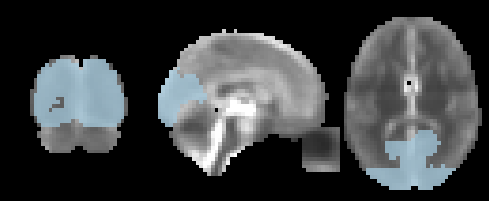

In [11]:
# Create V1 mask
roi_v1 = mean_img([img_atlas.slicer[..., v] for v in idx_v1])
img_roi = math_img("img>0", img=roi_v1)
img_resampled = resample_to_img(img_roi, img_mean)
mask_v1 = math_img("((mean!=0)*img)>0.5", mean=img_mean, img=img_resampled)

# Plotting V1 mask
plot_roi(mask_v1, img_mean, cmap='Paired', dim=-.5, draw_cross=False, annotate=False);

In [12]:
# Load A1 ROI labels
idx_a1 = [88, 89, 90, 91]
display(atlas_labels.iloc[idx_a1])

,name
index,
88,Left_Heschl's_Gyrus_(includes_H1_and_H2)
89,Right_Heschl's_Gyrus_(includes_H1_and_H2)
90,Left_Planum_Temporale
91,Right_Planum_Temporale


/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


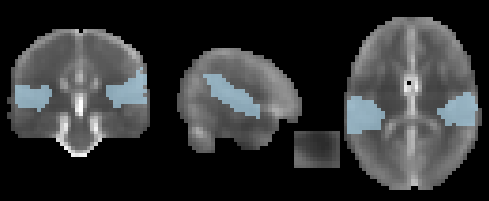

In [13]:
# Create A1 mask
roi_a1 = mean_img([img_atlas.slicer[..., a] for a in idx_a1])
img_roi = math_img("img>0", img=roi_a1)
img_resampled = resample_to_img(img_roi, img_mean)
mask_a1 = math_img("((mean!=0)*img)>0.5", mean=img_mean, img=img_resampled)

# Plotting V1 mask
plot_roi(mask_a1, img_mean, cmap='Paired', dim=-.5, draw_cross=False, annotate=False);

# Labels and chunks

Now that we have the dataset and the masks at hand, we're almost ready for some machine learning. Only thing still missing are the **target labels** (i.e. which samples / time-points are "eyes open" condition and which ones aren't, and **chunks/subject_identifier** to prevent data leakage between model training and validation.

From the last section of the [Machine Learning Preparation](machine_learning_preparation.ipynb) notebook, we know that we have a total of 384 volumes in our `dataset_ML.nii.gz` file and that it's always 4 volumes of the condition `eyes closed`, followed by 4 volumes of the condition `eyes open`, etc. Therefore our labels should be as follows:

In [14]:
labels = np.ravel([[['closed'] * 4, ['open'] * 4] for i in range(48)])
labels[:20]

array(['closed', 'closed', 'closed', 'closed', 'open', 'open', 'open',
       'open', 'closed', 'closed', 'closed', 'closed', 'open', 'open',
       'open', 'open', 'closed', 'closed', 'closed', 'closed'],
      dtype='<U6')

As mentioned above, the `chunks` variable is important if we want to do for example something like cross-validation. In our case we would ideally create 48 chunks, one for each subject. But because a cross-validation of 48 chunks takes very long, let's just create 6 chunks, containing always 8 subjects, i.e. 64 volumes in one group:

In [15]:
chunks = np.ravel([[i] * 64 for i in range(6)])
chunks[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

One way to do cross-validation is the so called **Leave-one-out cross-validation**. This approach trains on `(n - 1)` chunks, and classifies the remaining chunk, and repeats this for every chunk, also called **fold**. Therefore, a 6-fold cross-validation is one that divides the whole data into 6 different chunks.

# ROI-based decoding analysis

Now that the masks are ready, let's look at a ROI based decoding analysis. In other words, we'll use the response patterns of voxels in the mask to predict if the eyes were **closed** or **open** during a resting-state fMRI recording.

To setup the procedure let's perform the analysis first just for the **ROI of V1**.

In [16]:
mask2use = mask_v1

## Masking and Un-masking data

For the classification with `nilearn`, we need our functional data in a 2D, sample-by-voxel matrix. To get that, we'll select all the voxels within our `mask`. To do this, we can use the `NiftiMasker` object, which applies a mask to a dataset and returns the masked voxels flattened to a 2D matrix.

In [17]:
# Mask ML dataset with V1 ROI mask
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask2use, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)
print(samples)

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/input_data/base_masker.py:99: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


[[0.7897581  0.8949832  1.065642   ... 0.8487248  1.406102   1.6080661 ]
 [0.6634731  0.7264083  0.8240822  ... 1.206304   1.0572822  1.7161686 ]
 [0.5277856  0.87295365 1.3207896  ... 1.852575   1.2465636  1.7527636 ]
 ...
 [0.73879707 0.9643014  1.0316637  ... 1.0771223  0.60332584 1.0882887 ]
 [0.97698224 0.8522596  0.89267045 ... 0.71301985 0.8910863  1.051655  ]
 [0.70037246 0.8901158  0.91494864 ... 0.94807017 0.99307054 1.1872233 ]]


Its shape corresponds to the number of time-points times the number of voxels in the mask.

In [18]:
print(samples.shape)

(384, 2237)


To recover the original data shape (giving us a masked and z-scored BOLD series), we simply use the masker's inverse transform:

In [19]:
masked_epi = masker.inverse_transform(samples)

Let's now visualize the masked epi.

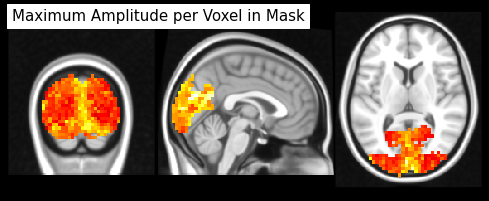

In [20]:
from nilearn.plotting import plot_stat_map

max_zscores = math_img("np.abs(img).max(axis=3)", img=masked_epi)
plot_stat_map(max_zscores, bg_img=anat, dim=-.5,
              draw_cross=False, annotate=False, colorbar=False,
              title='Maximum Amplitude per Voxel in Mask')

## Train/test split of dataset

To be able to test how well our model performs, we need to a test set, i.e. a dataset that wasn't used to train the model. The easiest solution to this is to use scikit-learns `train_test_split`.

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train_v1, X_test_v1, y_train_v1, y_test_v1, c_train, c_test = train_test_split(
    samples, labels=='open', chunks, test_size=64, random_state=0, shuffle=False)

print('Shapes of X:', X_train_v1.shape, X_test_v1.shape)
print('Shapes of y:', y_train_v1.shape, y_test_v1.shape)

Shapes of X: (320, 2237) (64, 2237)
Shapes of y: (320,) (64,)


## Training and testing a linear support vector machine (linear SVC) model for V1 ROI

In [22]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [23]:
# Create pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(multi_class='ovr', penalty='l2',
                      loss='squared_hinge', max_iter=500))
])

In [24]:
# Create parameter grid to be explored during grid search
grid = {
    'svc__C': np.logspace(-6, 2, num=40),
}

In [25]:
# Create grid search object with a cross-validation with LeaveOneGroupOut
from sklearn.model_selection import LeaveOneGroupOut
grid_cv_v1 = GridSearchCV(pipe, grid, cv=LeaveOneGroupOut(),
                          return_train_score=True, refit=True, n_jobs=-1, verbose=1)

In [26]:
# Train the model and find optimal hyperparameter
grid_cv_v1.fit(X=X_train_v1, y=y_train_v1, groups=c_train);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished


To better understand the model performance during the hyperparamter fine tuning, let's write a supportive plotting function.

In [27]:
def plot_hyperparam_fitting(cv_results):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(cv_results)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    display(df_pred.head())
    
    # Plot the model fit information
    df_plot = df_pred.sort_values('param_svc__C')

    # Exsract relevant modelling metrics
    train_scores = df_plot['mean_train_score']
    valid_scores = df_plot['mean_test_score']
    std_tr = df_plot['std_train_score']
    std_va = df_plot['std_test_score']

    plt.figure(figsize=(12, 4))
    Cs = df_plot['param_svc__C']
    plt.semilogx(Cs, train_scores, label='Training Set')
    plt.semilogx(Cs, valid_scores, label='Validation Set')

    # Add marker and text for best score
    max_id = np.argmax(valid_scores)
    x_pos = Cs.iloc[max_id]
    y_pos = valid_scores.iloc[max_id]
    txt = '{:0.4f}'.format(y_pos)
    plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
    plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

    # Quantify variance with ±std curves
    plt.fill_between(Cs.astype(float), train_scores-std_tr, train_scores+std_tr, alpha=0.3)
    plt.fill_between(Cs.astype(float), valid_scores-std_va, valid_scores+std_va, alpha=0.3)
    plt.ylabel('Performance metric')
    plt.xlabel('Model parameter')

    # Adjust x-lim, y-lim, add legend and adjust layout
    plt.legend()
    plt.show()

,param_svc__C,mean_test_score,std_test_score,mean_train_score,std_train_score
10,0.000112534,0.756250,0.042619,0.962500,0.008043
7,2.72833e-05,0.753125,0.053583,0.907813,0.010655
8,4.37548e-05,0.753125,0.051728,0.928125,0.007245
6,1.70125e-05,0.750000,0.046351,0.878125,0.016646
9,7.01704e-05,0.746875,0.049804,0.945312,0.007412


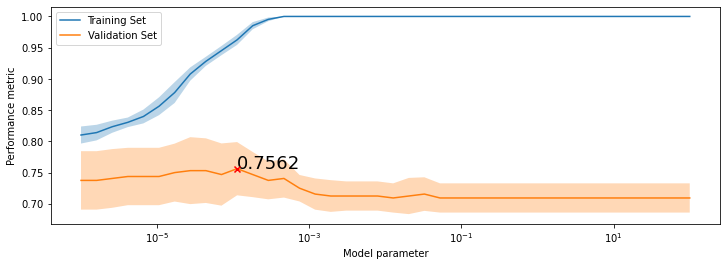

In [28]:
# Plot hyperparameter fine tuning outcome
plot_hyperparam_fitting(grid_cv_v1.cv_results_)

Now that the model is trained and we've verified that the fit seems reasonable, let's compute the models performance on the withheld test set.

In [29]:
score_test_v1 = grid_cv_v1.score(X_test_v1, y_test_v1)
print('Test score based on V1:', score_test_v1)

Test score based on V1: 0.734375


Given that the chance level is 50%, having ~73% accuracy on predicting if a person has eyes opened or closed during a resting state recording, only based on V1 information is rather good!

## Training and testing a linear support vector machine (linear SVC) model for A1 ROI

What about the **regions A1**?

In [30]:
# Mask ML dataset with A1 ROI mask
mask2use = mask_a1
masker = NiftiMasker(mask_img=mask2use, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/input_data/base_masker.py:99: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


In [31]:
# Split the data into training and test sets
X_train_a1, X_test_a1, y_train_a1, y_test_a1, c_train, c_test = train_test_split(
    samples, labels=='open', chunks, test_size=64, random_state=0, shuffle=False)

In [32]:
# Create grid search object with a cross-validation with LeaveOneGroupOut
grid_cv_a1 = GridSearchCV(pipe, grid, cv=LeaveOneGroupOut(),
                          return_train_score=True, refit=True, n_jobs=-1, verbose=1)

In [33]:
# Train the model and find optimal hyperparameter
grid_cv_a1.fit(X=X_train_a1, y=y_train_a1, groups=c_train);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.8s finished


,param_svc__C,mean_test_score,std_test_score,mean_train_score,std_train_score
39,100,0.534375,0.048814,1.000000,0.000000
15,0.00119378,0.534375,0.043526,0.999219,0.001563
38,62.3551,0.534375,0.048814,1.000000,0.000000
37,38.8816,0.534375,0.048814,1.000000,0.000000
36,24.2446,0.534375,0.048814,1.000000,0.000000


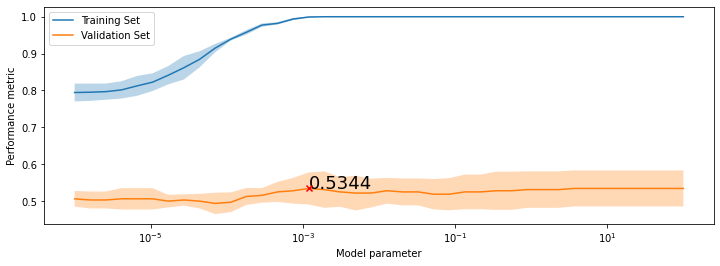

In [34]:
# Plot hyperparameter fine tuning outcome
plot_hyperparam_fitting(grid_cv_a1.cv_results_)

In [35]:
score_test_a1 = grid_cv_a1.score(X_test_a1, y_test_a1)
print('Test score based on A1:', score_test_a1)

Test score based on A1: 0.453125


Below chance level,... It makes sense that A1 would be somewhere around chance level, but this value is nonetheless a bit low. Let's come back to this later.

## Training and testing a linear support vector machine (linear SVC) model for eye ROI

Let's also check an obvious region to detect if eyes were opened or closed, the **eyes themselves**.

In [36]:
# Mask ML dataset with eye ROI mask
mask2use = mask_eye
masker = NiftiMasker(mask_img=mask2use, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/input_data/base_masker.py:99: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


In [37]:
# Split the data into training and test sets
X_train_eye, X_test_eye, y_train_eye, y_test_eye, c_train, c_test = train_test_split(
    samples, labels=='open', chunks, test_size=64, random_state=0, shuffle=False)

In [38]:
# Create grid search object with a cross-validation with LeaveOneGroupOut
grid_cv_eye = GridSearchCV(pipe, grid, cv=LeaveOneGroupOut(),
                           return_train_score=True, refit=True, n_jobs=-1, verbose=1)

In [39]:
# Train the model and find optimal hyperparameter
grid_cv_eye.fit(X=X_train_eye, y=y_train_eye, groups=c_train);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished


,param_svc__C,mean_test_score,std_test_score,mean_train_score,std_train_score
17,0.00307029,0.815625,0.040020,1.0,0.0
15,0.00119378,0.815625,0.036174,1.0,0.0
14,0.00074438,0.815625,0.036174,1.0,0.0
16,0.00191448,0.812500,0.035630,1.0,0.0
18,0.00492388,0.806250,0.033657,1.0,0.0


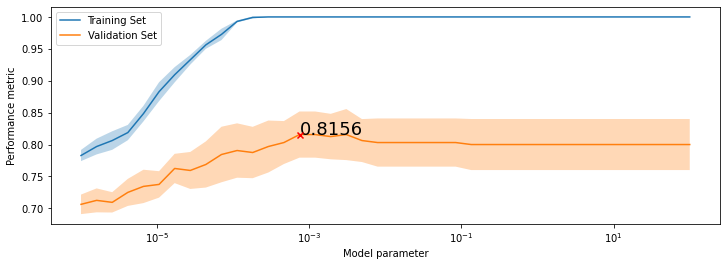

In [40]:
# Plot hyperparameter fine tuning outcome
plot_hyperparam_fitting(grid_cv_eye.cv_results_)

In [41]:
score_test_eye = grid_cv_eye.score(X_test_eye, y_test_eye)
print('Test score based on A1:', score_test_eye)

Test score based on A1: 0.921875


That's a very high score. Then again, not surprising for the eyes themselves.

## Conclusion of the ROI-based decoding analysis

In [42]:
df_res = pd.DataFrame([0.5, score_test_v1, score_test_a1, score_test_eye],
                      columns=['Accuracy'], index=['chance', 'V1', 'A1', 'eyes']).T.round(2)*100
df_res

,chance,V1,A1,eyes
Accuracy,50.0,73.0,45.0,92.0


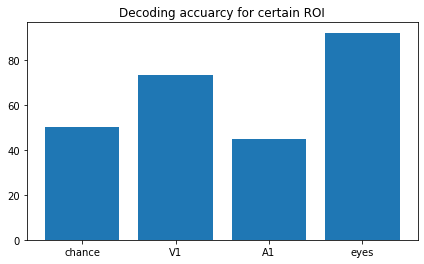

In [43]:
plt.figure(figsize=(7, 4))
plt.bar(df_res.columns, df_res.values.T.ravel())
plt.title('Decoding accuarcy for certain ROI');
print()

Picking one of the two classes "eyes-closed" or "eyes-open" would lead to a prediction accuracy of 50%, i.e. chance-level. Not surprisingly, the signal recorded within the eyes lead to the highest prediction accuracy, followed by the primary visual cortex, while the hopefully unrelated primary auditory cortex doesn't provide better prediction accuracy then the chance-level.

## Permutation testing

The approach above, with using a train and test set is important in machine learning to establish an optimized model and to judge how well it can generalize to a new dataset (here the test set).

One way to test the quality of the prediction accuracy is to run the cross-validation multiple times, but permutate the labels of the volumes randomly. Afterward we can compare the accuracy value of the correct labels to the ones with the random / false labels. Luckily `Scikit-learn` already has a function that does this for us. So let's do it.

**Note**: As a classifier, we will chose the best classifier/estimator from our grid search above. Additionally, we chose the number of iterations under `n_permutations` for the permutation testing rather low, to reduce computation time as well. This value should ideally be higher.

### Permuation testing for V1-ROI

In [44]:
from sklearn.model_selection import permutation_test_score

# Mask ML dataset with v1 ROI mask
mask2use = mask_v1
masker = NiftiMasker(mask_img=mask2use, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)

# Get best classifier from gridsearch
clf = grid_cv_v1.best_estimator_

# Run the permuation cross-validation
null_cv_scores = permutation_test_score(estimator=clf,
                                        X=samples,
                                        y=labels,
                                        groups=chunks,
                                        cv=LeaveOneGroupOut(),
                                        n_permutations=200,
                                        n_jobs=-1,
                                        verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   39.9s finished


So, let's take a look at the results:

Red line indicates accuracy of actual labels.
Prediction accuracy: 73.96
p-value: 0.0050


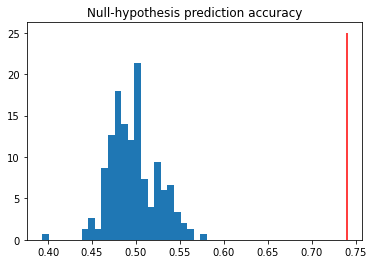

In [45]:
# Plotting the null distribution
plt.title('Null-hypothesis prediction accuracy')
plt.hist(null_cv_scores[1], bins=25, density=True);
plt.vlines(null_cv_scores[0], 0, 25, color='r')
print('Red line indicates accuracy of actual labels.')

print('Prediction accuracy: %.02f' % (null_cv_scores[0] * 100),
      'p-value: %.04f' % (null_cv_scores[2]),
      sep='\n')

Great! This means... Using resting-state fMRI images, we can predict if a person had their eyes open or closed with an accuracy significantly above chance level, when we only look at the activation from V1!

### Permuation testing for A1-ROI

In [46]:
from sklearn.model_selection import permutation_test_score

# Mask ML dataset with a1 ROI mask
mask2use = mask_a1
masker = NiftiMasker(mask_img=mask2use, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)

# Get best classifier from gridsearch
clf = grid_cv_a1.best_estimator_

# Run the permuation cross-validation
null_cv_scores = permutation_test_score(estimator=clf,
                                        X=samples,
                                        y=labels,
                                        groups=chunks,
                                        cv=LeaveOneGroupOut(),
                                        n_permutations=200,
                                        n_jobs=-1,
                                        verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   40.6s finished


So, let's take a look at the results:

Red line indicates accuracy of actual labels.
Prediction accuracy: 47.14
p-value: 0.8806


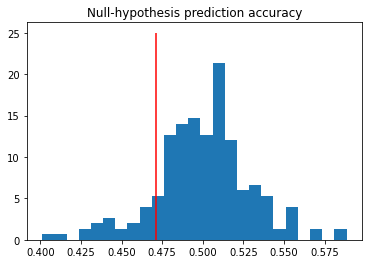

In [47]:
# Plotting the null distribution
plt.title('Null-hypothesis prediction accuracy')
plt.hist(null_cv_scores[1], bins=25, density=True);
plt.vlines(null_cv_scores[0], 0, 25, color='r')
print('Red line indicates accuracy of actual labels.')

print('Prediction accuracy: %.02f' % (null_cv_scores[0] * 100),
      'p-value: %.04f' % (null_cv_scores[2]),
      sep='\n')

As already seen before, using A1 to decode if somebody had eyes open or closed during the resting state recording doesn't work.

### Permuation testing for EYE-ROI

In [48]:
from sklearn.model_selection import permutation_test_score

# Mask ML dataset with eye ROI mask
mask2use = mask_eye
masker = NiftiMasker(mask_img=mask2use, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)

# Get best classifier from gridsearch
clf = grid_cv_eye.best_estimator_

# Run the permuation cross-validation
null_cv_scores = permutation_test_score(estimator=clf,
                                        X=samples,
                                        y=labels,
                                        groups=chunks,
                                        cv=LeaveOneGroupOut(),
                                        n_permutations=200,
                                        n_jobs=-1,
                                        verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished


So, let's take a look at the results:

Red line indicates accuracy of actual labels.
Prediction accuracy: 83.33
p-value: 0.0050


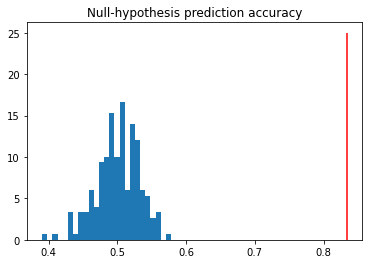

In [49]:
# Plotting the null distribution
plt.title('Null-hypothesis prediction accuracy')
plt.hist(null_cv_scores[1], bins=25, density=True);
plt.vlines(null_cv_scores[0], 0, 25, color='r')
print('Red line indicates accuracy of actual labels.')

print('Prediction accuracy: %.02f' % (null_cv_scores[0] * 100),
      'p-value: %.04f' % (null_cv_scores[2]),
      sep='\n')

And also here, the previous assumption gets supported. The eyes are of course a very good location to predict if a participant had eyes open or closed during a resting state recording.

# Investigation without prior knowledge / hypothesis?

In the previous example, we had some intuition/hypothesis which regions to look into. But this might not always be the case. So how can we get some ideas about which regions might be driving the classification accuracy, when one is looking at the whole brain?

There are many different ways to figure out which region is important for classification, but let us introduce you to two different approaches that you can use in `nilearn`: `SpaceNet` and  `Searchlight`

**Note:** For both of these examples we will take the full brain mask prepared above.

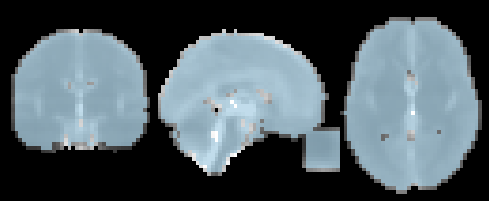

In [50]:
plot_roi(mask_global, img_mean, cmap='Paired', dim=-.5, draw_cross=False, annotate=False);

## SpaceNet: decoding with spatial structure for better maps

SpaceNet implements spatial penalties which improve brain decoding power as well as decoder maps. The results are brain maps which are both sparse (i.e regression coefficients are zero everywhere, except at predictive voxels) and structured (blobby). For more detail, check out `nilearn`'s section about [SpaceNet](http://nilearn.github.io/decoding/space_net.html).

To train a SpaceNet on our data, let's first split the data into a training set (chunk 0-4) and a test set (chunk 5). 

In [51]:
# Split the data into training and test sets
idx_train, idx_test, y_train, y_test, c_train, c_test = train_test_split(
    range(len(samples)), labels=='open', chunks, test_size=64, random_state=0, shuffle=False)

In [52]:
# Split the NIfTI image into train and test set
from nilearn.image import index_img
X_train = index_img(func, idx_train)
X_test = index_img(func, idx_test)

Now we can fit the SpaceNet to our data with a TV-l1 penalty. ***Note*** again, that we reduced the number of `max_iter` to have a quick computation. In a realistic case this value should be around 1000.

In [53]:
from nilearn.decoding import SpaceNetClassifier

# Fit model on train data and predict on test data
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=mask_global,
                             max_iter=10,
                             cv=5,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1,
                             n_jobs=-1)

decoder.fit(X_train, y_train)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 51, 41, 320),
affine=array([[  -4.,    0.,    0.,   78.],
       [   0.,    4.,    0., -114.],
       [   0.,    0.,    4.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/decoding/space_net.py:836: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  self.screening_percentile, self.mask_img_, verbose=self.verbose)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Time Elapsed: 8.10209 seconds, 0 minutes.


SpaceNetClassifier(alphas=None, cv=5, debias=False, eps=0.001,
          fit_intercept=True, high_pass=None, l1_ratios=0.5,
          loss='logistic', low_pass=None,
          mask=<nibabel.nifti1.Nifti1Image object at 0x7fffc633a690>,
          max_iter=10, memory=Memory(location=nilearn_cache/joblib),
          memory_level=2, n_alphas=10, n_jobs=-1, penalty='tv-l1',
          screening_percentile=20.0, standardize=True, t_r=None,
          target_affine=None, target_shape=None, tol=0.0001, verbose=1)

Now that the `SpaceNet` is fitted to the training data. Let's see how well it does in predicting the test data.

In [54]:
# Predict the labels of the test data
y_pred = decoder.predict(X_test)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 51, 41, 64),
affine=array([[  -4.,    0.,    0.,   78.],
       [   0.,    4.,    0., -114.],
       [   0.,    0.,    4.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


In [55]:
# Retrun average accuracy
accuracy = (y_pred == y_test).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)


TV-l1  classification accuracy : 85.9375%


Again above 80% prediction accuracy? But we wanted to know what's driving this prediction. So let's take a look at the fitting coefficients.

In [56]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_

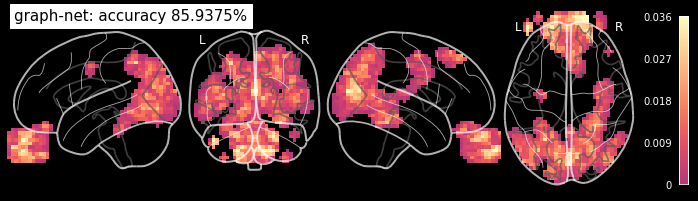

In [57]:
# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(coef_img, black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title='graph-net: accuracy %g%%' % accuracy)

Cool! As expected the visual cortex (in the back of the head) and the eyes are driving the classification!

## Searchlight: finding voxels containing information

Now the next question is: How high would the prediction accuracy be if we only take one small region to do the classification?

To answer this question we can use something that is called a **Searchlight** approach. The searchlight approach was first proposed by [Kriegeskorte et al., 2006](https://pdfs.semanticscholar.org/985c/ceaca8606443f9129616a26bbbbf952f2d7f.pdf). It is a widely used approach for the study of the fine-grained patterns of information in fMRI analysis. Its principle is relatively simple: a small group of neighboring features is extracted from the data, and the prediction function is instantiated on these features only. The resulting prediction accuracy is thus associated with all the features within the group, or only with the feature on the center. This yields a map of local fine-grained information, that can be used for assessing hypothesis on the local spatial layout of the neural code under investigation.

You can do a searchlight analysis in `nilearn` as follows:

In [58]:
# Specify the mask in which the searchlight should be performed
mask = mask_global

In [59]:
# Specify the classifier to use
# For presentation purpose, let's use a GaussainNB classifier to have rather small computation time
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [60]:
# Specify the radius of the searchlight sphere  that will scan the volume
# (the bigger the longer the computation)
sphere_radius = 8  # in mm

Now we're ready to create the searchlight object.

In [61]:
# Create searchlight object
from nilearn.decoding import SearchLight
from sklearn.model_selection import LeaveOneGroupOut
sl = SearchLight(mask_global,
                 process_mask_img=mask,
                 radius=sphere_radius,
                 estimator=clf,
                 cv=LeaveOneGroupOut(),
                 n_jobs=-1,
                 verbose=1)

In [62]:
# Run the searchlight algorithm
sl.fit(nb.load(func), labels, groups=chunks)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   25.4s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   29.7s finished


SearchLight(cv=LeaveOneGroupOut(),
      estimator=GaussianNB(priors=None, var_smoothing=1e-09),
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fffc633a690>,
      n_jobs=-1,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fffc633a690>,
      radius=8, scoring=None, verbose=1)

That took a while. So let's take a look at the results.

In [63]:
# First we need to put the searchlight output back into an MRI image
from nilearn.image import new_img_like
searchlight_img = new_img_like(func, sl.scores_)

Now we can plot the results. Let's plot it once on the glass brain and once from the side. For better interpretation on where the peaks are, let's set a minimum accuracy threshold of 60%.

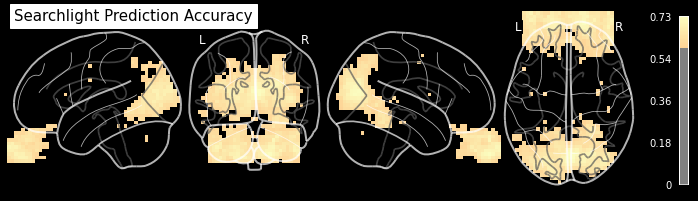

In [64]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(searchlight_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.6, cmap='magma', title='Searchlight Prediction Accuracy')

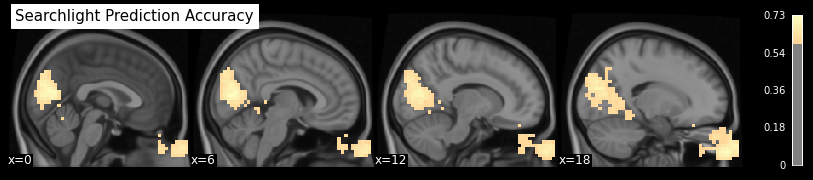

In [65]:
from nilearn.plotting import plot_stat_map
plot_stat_map(searchlight_img, cmap='magma', bg_img=anat, colorbar=True,
              display_mode='x', threshold=0.6, cut_coords=[0, 6, 12, 18],
              title='Searchlight Prediction Accuracy');

As expected and already seen before, the hotspots with high prediction accuracy are around the primary visual cortex (in the back of the head) and around the eyes.